#### Off Policy DQN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium
from collections import deque
import matplotlib.pyplot as plt
tf.keras.utils.disable_interactive_logging()

2024-12-12 16:51:19.342777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 16:51:21.175695: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick/miniconda3/envs/tf_env/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/nick/miniconda3/envs/tf_env/lib/
2024-12-12 16:51:21.175827: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nick

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
env = gymnasium.make("CartPole-v1")

In [4]:
input_shape = env.observation_space.shape[0]
n_outputs = env.action_space.n

q_net = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[input_shape]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target_net = keras.models.clone_model(q_net)
target_net.set_weights(q_net.get_weights())

In [5]:
replay_buffer = deque(maxlen=50000)
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

discount_factor = 0.95
batch_size=32
total_losses = []

In [6]:
class DqnAgent:
    def __init__(self, env, q_net, target_net, discount_factor, replay_buffer, loss_fn, optimizer):
        self.env = env
        self.q_net = q_net
        self.target_net = target_net
        self.discount_factor = discount_factor
        self.replay_buffer = replay_buffer
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        self.epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=1.0,
                        decay_steps=1400,
                        end_learning_rate=0.01
                        )


    def greedy_policy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        q_values = self.q_net.predict(state[np.newaxis])
        return np.argmax(q_values[0])

    def collect_step(self, state, iteration):
        epsilon = self.epsilon_fn(iteration)
        action = self.greedy_policy(state, epsilon)
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        self.replay_buffer.append((state, action, reward, next_state, done))
        return next_state, reward, done

    def initialize_buffer(self, n_max_steps):
        state, _ = self.env.reset()
        for step in range(n_max_steps):
            action = self.env.action_space.sample()
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            if done:
                state, _ = self.env.reset()
                
    
    def train_step(self, batch_size):
        random_indices = np.random.randint(0, len(self.replay_buffer), batch_size)
        samples = [self.replay_buffer[index] for index in random_indices]
        states, actions, rewards, next_states, dones = [np.array([sample[index] for sample in samples]) for index in range(5)]

        target_q_values = self.q_net.predict(next_states)
        target_mask = tf.one_hot(np.argmax(target_q_values, axis=1) ,n_outputs).numpy()

        target_max_q_values = (self.target_net.predict(next_states) * target_mask).sum(axis=1)
        target_max_q_values = (rewards + target_max_q_values * self.discount_factor * (1-dones))
        target_max_q_values = target_max_q_values.reshape(-1, 1)

        q_mask = tf.one_hot(actions, n_outputs)
        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_values = tf.reduce_sum(q_values * q_mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_max_q_values, q_values))
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

In [7]:
agent = DqnAgent(
    env=env,
    q_net=q_net,
    target_net=target_net,
    discount_factor=0.99,
    replay_buffer=replay_buffer,
    loss_fn=loss_fn,
    optimizer=optimizer
)

In [8]:
n_iterations = 1500
n_max_steps = 200

total_rewards = []
for iteration in range(n_iterations):
    state, _ = env.reset()
    episode_reward = 0
    for step in range(n_max_steps):
        state, reward, done = agent.collect_step(state, iteration)
        episode_reward += reward
        if done:
            break
    total_rewards.append(episode_reward)
    print("\rIteration: {}, Steps: {}, eps: {:.3f}".format(iteration, step + 1, agent.epsilon_fn(iteration)), end="")
    agent.train_step(batch_size=32)
    if iteration % 50 == 0:
        agent.target_net.set_weights(agent.q_net.get_weights())
    if iteration % 100 == 0:
        tf.keras.backend.clear_session()

Iteration: 0, Steps: 11, eps: 1.000WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f1c80528c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration: 1499, Steps: 91, eps: 0.0100

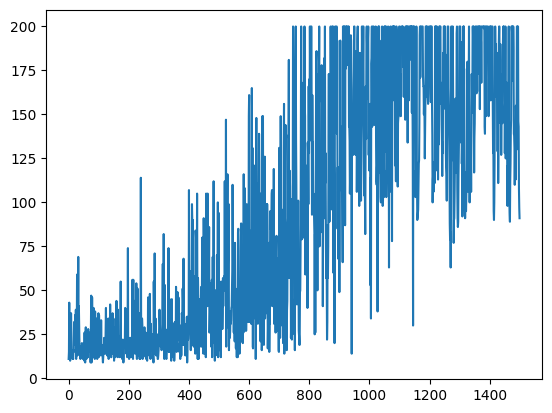

In [10]:
plt.plot(total_rewards)